In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvx_portfolio as cp

plotdir = '../portfolio/plots/'

sigmas=pd.read_csv('sigmas.csv.gz',index_col=0,parse_dates=[0])
returns=pd.read_csv('returns.csv.gz',index_col=0,parse_dates=[0])
volumes=pd.read_csv('volumes.csv.gz',index_col=0,parse_dates=[0])
a = pd.read_csv('a.csv.gz',index_col=0,parse_dates=[0])
b = pd.read_csv('b.csv.gz',index_col=0,parse_dates=[0])
s = pd.read_csv('s.csv.gz',index_col=0,parse_dates=[0])

w_b = pd.Series(index=returns.columns, data=1)
w_b.USDOLLAR = 0.
w_b/=sum(w_b)

start_t="2012-01-01"
end_t="2016-12-31"

simulated_tcost = cp.TcostModel(volumes, sigmas, a, b, cash_key='USDOLLAR')
simulated_hcost = cp.HcostModel(s, cash_key='USDOLLAR')
simulator = cp.MarketSimulator(returns, volumes, [simulated_tcost, simulated_hcost], cash_key='USDOLLAR')

return_estimate=pd.read_csv('return_estimate.csv.gz',index_col=0,parse_dates=[0])
volume_estimate=pd.read_csv('volume_estimate.csv.gz',index_col=0,parse_dates=[0])
sigma_estimate=pd.read_csv('sigma_estimate.csv.gz',index_col=0,parse_dates=[0])

alpha_model = cp.AlphaSource(return_estimate)
optimization_tcost=cp.TcostModel(volume_estimate, sigma_estimate, a, b, cash_key='USDOLLAR')
optimization_hcost=cp.HcostModel(s, cash_key='USDOLLAR')

risk_data = pd.HDFStore('risk_model.h5')
risk_model = cp.FactorModelSigma(risk_data.exposures, risk_data.factor_sigma, risk_data.idyos)

results={}

# SPO coarse search

In [2]:
policies={}
gamma_risks_coarse=[ 20, 50, 100, 200, 500, 1000, 2000]
gamma_tcosts_coarse=[ 20, 50, 100, 200, 500, 1000, 2000]
for gamma_risk in gamma_risks_coarse:
    for gamma_tcost in gamma_tcosts_coarse : 
        policies[(gamma_risk, gamma_tcost)] = \
      cp.SinglePeriodOpt(alpha_model, [gamma_risk*risk_model,gamma_tcost*optimization_tcost,optimization_hcost], 
                                [cp.LeverageLimit(3)])

import warnings
warnings.filterwarnings('ignore')
results.update(dict(zip(policies.keys(), simulator.run_multiple_backtest(1E8*w_b, start_time=start_t,end_time=end_t,
                                              policies=policies.values(), parallel=True))))

result_df_coarse=pd.DataFrame()
for k in results:
    if k[0] in gamma_risks_coarse and k[1] in gamma_tcosts_coarse:
        result_df_coarse.loc[k[0], k[1]] = results[k]
        
result_df = result_df_coarse

ERROR:root:The solver None failed. Defaulting to no trades
ERROR:root:The solver None failed. Defaulting to no trades
ERROR:root:The solver None failed. Defaulting to no trades
ERROR:root:The solver None failed. Defaulting to no trades
ERROR:root:The solver None failed. Defaulting to no trades
ERROR:root:The solver None failed. Defaulting to no trades
ERROR:root:The solver None failed. Defaulting to no trades
ERROR:root:The solver None failed. Defaulting to no trades
ERROR:root:The solver None failed. Defaulting to no trades
ERROR:root:The solver None failed. Defaulting to no trades
ERROR:root:The solver None failed. Defaulting to no trades
ERROR:root:The solver None failed. Defaulting to no trades
ERROR:root:The solver None failed. Defaulting to no trades
ERROR:root:The solver None failed. Defaulting to no trades
ERROR:root:The solver None failed. Defaulting to no trades
ERROR:root:The solver None failed. Defaulting to no trades
ERROR:root:The solver None failed. Defaulting to no trad

In [3]:
# result_df=pd.DataFrame()
# for k in results:
#     result_df.loc[k[0], k[1]] = results[k]
# result_df.index.name = 'gamma_risk'
# result_df.columns.name = 'gamma_tcost'
# result_df = result_df.reindex(index=sorted(result_df.index),columns=sorted(result_df.columns))

# benchmark_returns = returns.loc[(returns.index>=start_t)&(returns.index<=end_t)].USDOLLAR

# result_df_used= result_df#[[100.,300.,1000.]]

# table=pd.DataFrame()
# table[r'Excess return']=\
# result_df_used.applymap(lambda res: 100*250*(res.returns - benchmark_returns).mean()).unstack()
# table[r'Excess risk']= \
#     result_df_used.applymap(lambda res: np.std(benchmark_returns - res.returns)*100*np.sqrt(250)).unstack()
# table[r'Transaction costs']=\
#     result_df_used.applymap(lambda res: (res.simulator_TcostModel.sum(1)/res.v).mean() * 100 * 250).unstack()  

# table['SR']=\
#     result_df_used.applymap(lambda res: res.sharpe_ratio).unstack()  


# table
# #table_print=pd.DataFrame(table,copy=True)
# #table_print=table_print.set_index(table_print.index.set_levels([["%g"%i for i in table_print.index.levels[0]],
# #                      ["%g"%i for i in table_print.index.levels[1]]]))
# #table_print.ix[:,:]=table_print.ix[:,:].applymap(lambda x: r'%.2f%%'%x )
# #print(table_print.to_latex(float_format='%.2f', escape=False).replace('%',r'\%'))

Excess return  Excess risk  Transaction costs  \
gamma_tcost gamma_risk                                                  
20          20              34.855836    96.582393         565.625462   
            50              23.243200    81.113666         522.365666   
            100             13.353205    67.085782         474.700347   
            200              4.917512    53.845423         419.770245   
            500             -2.661154    40.084891         345.938392   
            1000            -5.982110    32.678140         293.844015   
            2000            -7.144917    24.395387         240.590274   
50          20              23.970350    39.937253         273.293358   
            50              21.120877    36.592002         266.862046   
            100             18.002463    33.367536         257.515805   
            200             15.002591    29.677108         242.409947   
            500             12.166682    24.067757         213.493113   
            1000            11.527588    19.389791         184.536231   
            2000            11.312016    14.255024         150.326402   
100         20              40.388517    17.974569          61.880949   
            50              39.029125    16.103987          62.308807   
            100             37.723784    14.749114          62.377783   
            200             36.239926    13.328718          61.459965   
            500             33.275910    10.922233          58.794643   
            1000            29.448454     8.768407          55.748258   
            2000            25.445247     7.033540          51.316468   
200         20              30.007555    12.977282           9.159899   
            50              28.954417    11.742450           9.420569   
            100             27.559711    10.433940           9.663036   
            200             25.463148     8.740613          10.026685   
            500             22.182611     6.259197          10.365118   
            1000            19.720076     4.970115          10.414273   
            2000            17.388691     4.092554          10.176731   
500         20               8.372577     7.762771           0.264756   
            50               5.151915     5.939196           0.290706   
            100              3.921940     5.082857           0.303166   
            200              3.316512     4.310583           0.310135   
            500              2.377222     3.561255           0.321802   
            1000             1.659300     3.036232           0.328598   
            2000             1.210320     2.451491           0.328049   
1000        20              15.879955    13.564913           0.001205   
            50              15.650980    13.337733           0.001330   
            100             15.188152    12.874009           0.001724   
            200             13.698745    11.378432           0.003214   
            500              8.888851     6.545110           0.007605   
            1000             5.950460     4.675861           0.010451   
            2000             3.808289     3.953000           0.014415   
2000        20              15.972146    13.705617           0.000007   
            50              15.971409    13.704857           0.000007   
            100             15.970207    13.703627           0.000007   
            200             15.967594    13.700923           0.000008   
            500             15.907478    13.631168           0.000045   
            1000            13.779017    10.854018           0.001806   
            2000            10.008736     7.366750           0.005486   

                              SR  
gamma_tcost gamma_risk            
20          20          0.362333  
            50          0.287695  
            100         0.199841  
            200         0.091691  
            500        -0.066653  
            1000       -0.183792  
            2000    

### DOnt plot gamma trade = 30, get rid of turnover 

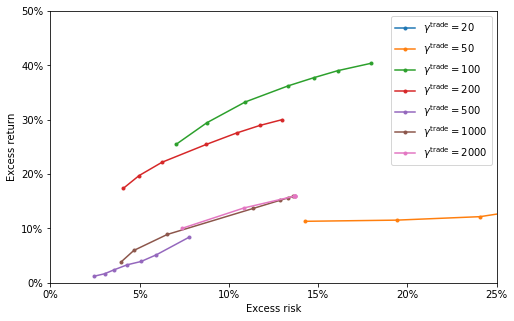

In [21]:
plt.figure(figsize=(8,5))
for gamma_tcost in result_df.columns:
    x=[el.excess_returns.std()*100*np.sqrt(250) for el in result_df[gamma_tcost]]
    y=[el.excess_returns.mean()*100*250 for el in result_df[gamma_tcost]]
    plt.plot(np.array(x),np.array(y), '.-', label='$\gamma^\mathrm{trade} = %g$'%gamma_tcost)
plt.legend(loc='upper right')
plt.xlabel('Excess risk')
plt.ylabel('Excess return')
plt.xlim([0,25])
plt.ylim([0,50])


import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))

plt.savefig(plotdir+'spo_riskrewardfrontier.png')

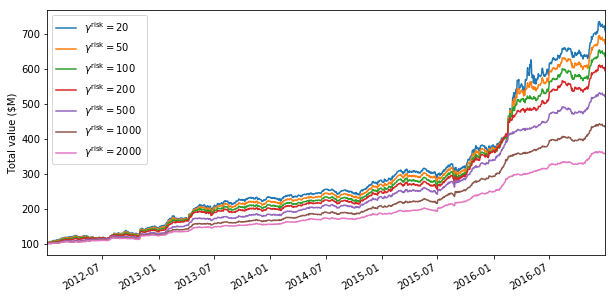

In [22]:
gamma_tcost=100#
plt.figure(figsize=(10,5))

[(results[(i, gamma_tcost)].v/1E6).plot(label='$\gamma^\mathrm{risk} = %g$'%i) for i in gamma_risks]
plt.legend(loc='upper left')# if i==0 else 'upper left')
plt.ylabel('Total value (\$M)')
plt.savefig(plotdir+'spo_valueintime.png')

In [6]:
result_df.applymap(lambda x: x.sharpe_ratio)

gamma_tcost,20,50,100,200,500,1000,2000
gamma_risk,,,,,,,
20,0.362333,0.602596,2.255951,2.321545,1.082861,1.175337,1.170024
50,0.287695,0.579503,2.433244,2.475634,0.870906,1.178121,1.170035
100,0.199841,0.541674,2.567909,2.651897,0.774682,1.184463,1.170052
200,0.091691,0.507545,2.729790,2.924829,0.772460,1.208728,1.170092
500,-0.066653,0.507536,3.058784,3.558150,0.670188,1.363512,1.171652
1000,-0.183792,0.596892,3.371880,3.983569,0.548681,1.277672,1.274553
2000,-0.294049,0.796714,3.632143,4.265822,0.495678,0.967238,1.364060


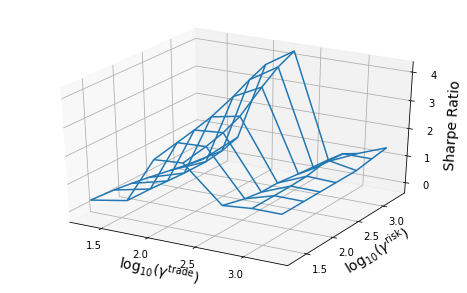

In [59]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111, projection='3d')

# Grab some test data.
X, Y, Z = axes3d.get_test_data(0.05)

X,Y=np.meshgrid(np.log10(gamma_risks), np.log10(gamma_tcosts))
Z=result_df.applymap(lambda x: x.sharpe_ratio).values

# Plot a basic wireframe.
ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1)

ax.set_xlabel(r'$\log_{10}(\gamma^\mathrm{trade})$', fontsize=14, rotation=150)
ax.set_xticks([1.5, 2, 2.5,  3])

ax.set_ylabel(r'$\log_{10}(\gamma^\mathrm{risk})$', fontsize=14)
ax.set_yticks([1.5, 2, 2.5,  3])

ax.set_zlabel(r'Sharpe Ratio', fontsize=14, rotation=60)

plt.savefig(plotdir+'spo_sharperatio.png')

In [7]:
result_df.applymap(lambda x: x.policy_time.mean() + x.simulation_time.mean())

gamma_tcost,20,50,100,200,500,1000,2000
gamma_risk,,,,,,,
20,0.970576,1.289578,1.148465,1.207216,1.363264,1.297289,1.001496
50,1.037761,1.234371,1.337603,1.221546,1.197139,1.171640,1.296287
100,1.252211,1.315627,1.174067,1.334544,1.226255,1.298213,1.062841
200,1.165531,1.073503,1.113728,1.338943,0.972779,1.059031,1.037454
500,1.254542,1.308923,1.347249,1.289306,1.381967,1.315777,1.290451
1000,1.292408,0.920661,0.880358,1.222515,1.145747,1.222761,1.005543
2000,1.279197,1.071255,1.333925,1.144716,1.369475,1.336398,1.235377


In [8]:
result_df.applymap(lambda x: x.policy_time.sum() + x.simulation_time.sum())

gamma_tcost,20,50,100,200,500,1000,2000
gamma_risk,,,,,,,
20,1220.984895,1622.288832,1444.768626,1518.677508,1714.985745,1631.989510,1259.881576
50,1305.503815,1552.838130,1682.704331,1536.705215,1506.001161,1473.922528,1630.729411
100,1575.280958,1655.059062,1476.976121,1678.856725,1542.628384,1633.151917,1337.053602
200,1466.237566,1350.466360,1401.070090,1684.389899,1223.756197,1332.260729,1305.116820
500,1578.213475,1646.625562,1694.839037,1621.946957,1738.515054,1655.246918,1623.387516
1000,1625.849210,1158.191407,1107.490573,1537.923647,1441.349694,1538.233874,1264.972948
2000,1609.229283,1347.638781,1678.078134,1440.052629,1722.799760,1681.189152,1554.104712


## Other diagnostics

([20, 50, 100, 200, 500, 1000, 2000], 2000)

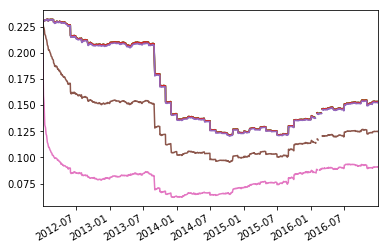

In [9]:
gamma_tcost=gamma_tcosts[-1]
[(np.sqrt(250)*np.sqrt(results[(i, gamma_tcost)].policy_FactorModelSigma)).plot() for i in gamma_risks]
gamma_risks, gamma_tcost

([20, 50, 100, 200, 500, 1000, 2000], 100)

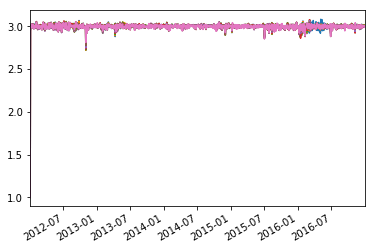

In [10]:
# [results[(i, gamma_tcosts[2])].leverage.plot() for i in gamma_risks]
# gamma_risks, gamma_tcosts[2]

([20, 50, 100, 200, 500, 1000, 2000], 50)

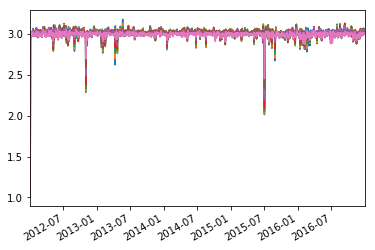

In [11]:
# [results[(i, gamma_tcosts[1])].leverage.plot() for i in gamma_risks]
# gamma_risks, gamma_tcosts[1]

([20, 50, 100, 200, 500, 1000, 2000], 100)

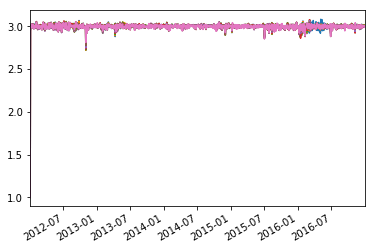

In [12]:
# [results[(i, gamma_tcosts[2])].leverage.plot() for i in gamma_risks]
# gamma_risks, gamma_tcosts[2]

([20, 50, 100, 200, 500, 1000, 2000], 100)

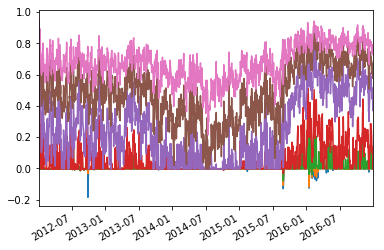

In [13]:
# [results[(i, gamma_tcosts[2])].w.USDOLLAR.plot() for i in gamma_risks]
# gamma_risks, gamma_tcosts[2]

([20, 50, 100, 200, 500, 1000, 2000], 100)

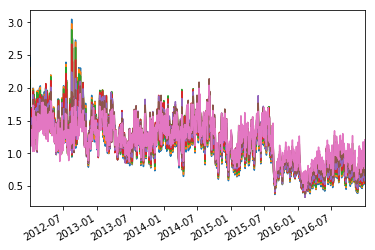

In [14]:
# [results[(i, gamma_tcosts[2])].turnover.plot() for i in gamma_risks]
# gamma_risks, gamma_tcosts[2]

# SPO fine Search 

In [25]:
policies={}
gamma_risks_fine=[ .5, 2, 10, 50, 200, 1000, 5000, 20000, 100000, 500000]
gamma_tcosts_fine=[70, 100, 140, 200, 280] # equispaced in log10 space
for gamma_risk in gamma_risks_fine:
    for gamma_tcost in gamma_tcosts_fine : 
        policies[(gamma_risk, gamma_tcost)] = \
      cp.SinglePeriodOpt(alpha_model, [gamma_risk*risk_model,gamma_tcost*optimization_tcost,optimization_hcost], 
                                [cp.LeverageLimit(3)])

import warnings
warnings.filterwarnings('ignore')
results.update(dict(zip(policies.keys(), simulator.run_multiple_backtest(1E8*w_b, start_time=start_t,end_time=end_t,
                                              policies=policies.values(), parallel=True))))

result_df_fine=pd.DataFrame()
for k in results:
    if k[0] in gamma_risks_fine and k[1] in gamma_tcosts_fine:
        result_df_coarse.loc[k[0], k[1]] = results[k]
        
result_df = result_df_fine

ERROR:root:The solver None failed. Defaulting to no trades
ERROR:root:The solver None failed. Defaulting to no trades
ERROR:root:The solver None failed. Defaulting to no trades
ERROR:root:The solver None failed. Defaulting to no trades
ERROR:root:The solver None failed. Defaulting to no trades
ERROR:root:The solver None failed. Defaulting to no trades
ERROR:root:The solver None failed. Defaulting to no trades
ERROR:root:The solver None failed. Defaulting to no trades
ERROR:root:The solver None failed. Defaulting to no trades
ERROR:root:The solver None failed. Defaulting to no trades
ERROR:root:The solver None failed. Defaulting to no trades
ERROR:root:The solver None failed. Defaulting to no trades
ERROR:root:The solver None failed. Defaulting to no trades
ERROR:root:The solver None failed. Defaulting to no trades
ERROR:root:The solver None failed. Defaulting to no trades
ERROR:root:The solver None failed. Defaulting to no trades
ERROR:root:The solver None failed. Defaulting to no trad

### Update table

In [26]:
# result_df=pd.DataFrame()
# for k in results:
#     result_df.loc[k[0], k[1]] = results[k]
# result_df.index.name = 'gamma_risk'
# result_df.columns.name = 'gamma_tcost'
# result_df = result_df.reindex(index=sorted(result_df.index),columns=sorted(result_df.columns))

# benchmark_returns = returns.loc[(returns.index>=start_t)&(returns.index<=end_t)].USDOLLAR
# table=pd.DataFrame()
# table[r'Excess return']=\
# result_df.applymap(lambda res: 100*250*(res.returns - benchmark_returns).mean()).unstack()
# table[r'Excess risk']= \
#     result_df.applymap(lambda res: np.std(benchmark_returns - res.returns)*100*np.sqrt(250)).unstack()
# table[r'Transaction costs']=\
#     result_df.applymap(lambda res: (res.simulator_TcostModel.sum(1)/res.v).mean() * 100 * 250).unstack()  
# table['SR']=\
#     result_df.applymap(lambda res: res.sharpe_ratio).unstack()  

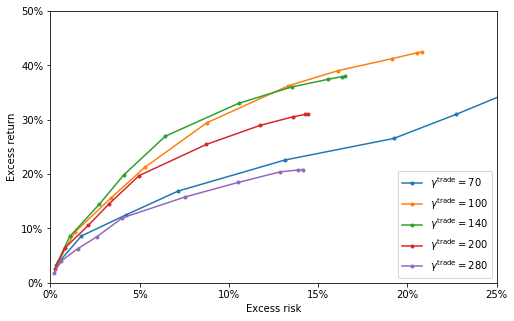

In [34]:
result_df=pd.DataFrame()
for k in results:
    result_df.loc[k[0], k[1]] = results[k]

plt.figure(figsize=(8,5))
for gamma_tcost in result_df.columns:
    x=[el.excess_returns.std()*100*np.sqrt(250) for el in result_df[gamma_tcost]]
    y=[el.excess_returns.mean()*100*250 for el in result_df[gamma_tcost]]
    plt.plot(np.array(x),np.array(y), '.-', label='$\gamma^\mathrm{trade} = %g$'%gamma_tcost)
plt.legend(loc='lower right')
plt.xlabel('Excess risk')
plt.ylabel('Excess return')
plt.xlim([0,25])
plt.ylim([0,50])


import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))

plt.savefig(plotdir+'spo_riskrewardfrontier_fine.png')

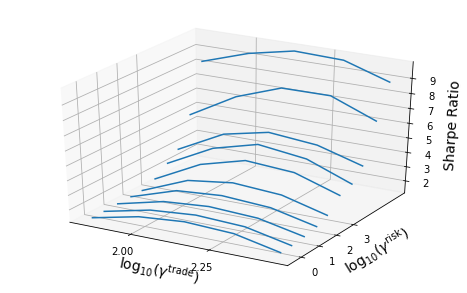

In [33]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111, projection='3d')

X,Y=np.meshgrid(np.log10(gamma_tcosts), np.log10(gamma_risks))
Z=result_df.applymap(lambda x: x.sharpe_ratio).values

# Plot a basic wireframe.
ax.plot_wireframe(X, Y, Z, rstride=1, cstride=0)

ax.set_ylabel(r'$\log_{10}(\gamma^\mathrm{risk})$', fontsize=14)
ax.set_yticks([0, 1, 2,  3])

ax.set_xlabel(r'$\log_{10}(\gamma^\mathrm{trade})$', fontsize=14, rotation=150)
ax.set_xticks([ 2, 2.25])

ax.set_zlabel(r'Sharpe Ratio', fontsize=14, rotation=60)

plt.savefig(plotdir+'spo_sharperatio_fine.png')

In [24]:
# np.log(result_df.iloc[-1,-1].v).plot()
# np.log(1e8*(result_df.iloc[-1,-1].risk_free_returns+1).cumprod()).plot()

In [15]:
# res.turnover.plot()
# res.policy_TcostModel.sum(1).plot(secondary_y=True)

In [16]:
# res.policy_TcostModel.sum(1).plot()
# res.simulator_TcostModel.sum(1).plot(secondary_y=True)

In [17]:
# (res.policy_TcostModel.sum(1)).tail(100).plot(style='.-')
# (res.simulator_TcostModel.sum(1)/res.v).tail(100).plot(style='.-')

In [38]:
result_df

,70,100,140,200,280
0.5,<cvx_portfolio.result.SimulationResult object ...,<cvx_portfolio.result.SimulationResult object ...,<cvx_portfolio.result.SimulationResult object ...,<cvx_portfolio.result.SimulationResult object ...,<cvx_portfolio.result.SimulationResult object ...
2.0,<cvx_portfolio.result.SimulationResult object ...,<cvx_portfolio.result.SimulationResult object ...,<cvx_portfolio.result.SimulationResult object ...,<cvx_portfolio.result.SimulationResult object ...,<cvx_portfolio.result.SimulationResult object ...
10.0,<cvx_portfolio.result.SimulationResult object ...,<cvx_portfolio.result.SimulationResult object ...,<cvx_portfolio.result.SimulationResult object ...,<cvx_portfolio.result.SimulationResult object ...,<cvx_portfolio.result.SimulationResult object ...
50.0,<cvx_portfolio.result.SimulationResult object ...,<cvx_portfolio.result.SimulationResult object ...,<cvx_portfolio.result.SimulationResult object ...,<cvx_portfolio.result.SimulationResult object ...,<cvx_portfolio.result.SimulationResult object ...
200.0,<cvx_portfolio.result.SimulationResult object ...,<cvx_portfolio.result.SimulationResult object ...,<cvx_portfolio.result.SimulationResult object ...,<cvx_portfolio.result.SimulationResult object ...,<cvx_portfolio.result.SimulationResult object ...
1000.0,<cvx_portfolio.result.SimulationResult object ...,<cvx_portfolio.result.SimulationResult object ...,<cvx_portfolio.result.SimulationResult object ...,<cvx_portfolio.result.SimulationResult object ...,<cvx_portfolio.result.SimulationResult object ...
5000.0,<cvx_portfolio.result.SimulationResult object ...,<cvx_portfolio.result.SimulationResult object ...,<cvx_portfolio.result.SimulationResult object ...,<cvx_portfolio.result.SimulationResult object ...,<cvx_portfolio.result.SimulationResult object ...
20000.0,<cvx_portfolio.result.SimulationResult object ...,<cvx_portfolio.result.SimulationResult object ...,<cvx_portfolio.result.SimulationResult object ...,<cvx_portfolio.result.SimulationResult object ...,<cvx_portfolio.result.SimulationResult object ...
100000.0,<cvx_portfolio.result.SimulationResult object ...,<cvx_portfolio.result.SimulationResult object ...,<cvx_portfolio.result.SimulationResult object ...,<cvx_portfolio.result.SimulationResult object ...,<cvx_portfolio.result.SimulationResult object ...
500000.0,<cvx_portfolio.result.SimulationResult object ...,<cvx_portfolio.result.SimulationResult object ...,<cvx_portfolio.result.SimulationResult object ...,<cvx_portfolio.result.SimulationResult object ...,<cvx_portfolio.result.SimulationResult object ...


# MPO 

In [40]:
all_return_estimates={}
n_p1=returns.shape[1]
T=returns.shape[0]

# add the SPO predictions
for i,t in enumerate(returns.index[:-1]):
    all_return_estimates[(t,t)]=return_estimate.loc[t]

std_second_prediction=0.14

np.random.seed(100)
# make new predictions
for i,t in enumerate(returns.index[:-1]):
    tp1 = returns.index[i+1] 
    all_return_estimates[(t,tp1)]=returns.loc[tp1]+std_second_prediction*np.random.randn(n_p1)
    all_return_estimates[(t,tp1)].USDOLLAR=returns.loc[tp1].ix[-1]
    
    
alpha_model = cp.MPOAlphaSource(all_return_estimates)
results_MPO={}

In [41]:
import cvxpy as cvx

policies={}
gamma_risks_MPO=[20.,200.,2000]#[ 20., 50,  200., 500., 2000.,5000.]
gamma_tcosts_MPO=[ 100., 140.,200.]
for gamma_risk in gamma_risks_MPO:
    for gamma_tcost in gamma_tcosts_MPO : 
        policies[(gamma_risk, gamma_tcost)] = \
      cp.MultiPeriodOpt(alpha_model=alpha_model, 
                          costs=[gamma_risk*risk_model, gamma_tcost*optimization_tcost, optimization_hcost], 
                          constraints=[cp.LeverageLimit(3)],
                          trading_times=list(returns.index[(returns.index>=start_t)&(returns.index<=end_t)]),
                         lookahead_periods=2,
                         terminal_weights=None)#,solver=cvx.SCS)

results_MPO.update({k:v for k,v in zip(policies.keys(),
                           simulator.run_multiple_backtest(w_b*1e8, start_time = start_t, end_time="2016-12-29", 
                                          policies=policies.values(),parallel=True))})

result_df_MPO=pd.DataFrame()
for k in results:
    if k[0] in gamma_risks_MPO and k[1] in gamma_tcosts_MPO:
        result_df_MPO.loc[k[0], k[1]] = results_MPO[k]
        
result_df_MPO=result_df_MPO.loc[sorted(result_df_MPO.index)]

AssertionError: 

In [ ]:
plt.figure(figsize=(8,5))

for gamma_tcost in result_df_MPO.columns:
    x=[el.excess_returns.std()*100*np.sqrt(250) for el in result_df[gamma_tcost]]
    y=[el.excess_returns.mean()*100*250 for el in result_df[gamma_tcost]]
    plt.plot(np.array(x),np.array(y), '.-', label='$\gamma^\mathrm{trade} = %g$'%gamma_tcost)
plt.legend(loc='lower right')
plt.xlabel('Excess risk')
plt.ylabel('Excess return')
plt.xlim([0,25])
plt.ylim([0,55])

import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))

plt.savefig(plotdir+'mpo_riskrewardfrontier.png')